# Practical Session on Graph Neural Networks

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning).

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [3]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [4]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [5]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [6]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [7]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6380
F1-Score: 0.4578
Epoch 00002 | Loss: 0.5810
Epoch 00003 | Loss: 0.5622
Epoch 00004 | Loss: 0.5554
Epoch 00005 | Loss: 0.5505
Epoch 00006 | Loss: 0.5458
F1-Score: 0.5111
Epoch 00007 | Loss: 0.5421
Epoch 00008 | Loss: 0.5383
Epoch 00009 | Loss: 0.5345
Epoch 00010 | Loss: 0.5314
Epoch 00011 | Loss: 0.5288
F1-Score: 0.5136
Epoch 00012 | Loss: 0.5261
Epoch 00013 | Loss: 0.5236
Epoch 00014 | Loss: 0.5212
Epoch 00015 | Loss: 0.5189
Epoch 00016 | Loss: 0.5165
F1-Score: 0.5284
Epoch 00017 | Loss: 0.5142
Epoch 00018 | Loss: 0.5119
Epoch 00019 | Loss: 0.5097
Epoch 00020 | Loss: 0.5075
Epoch 00021 | Loss: 0.5054
F1-Score: 0.5389
Epoch 00022 | Loss: 0.5033
Epoch 00023 | Loss: 0.5012
Epoch 00024 | Loss: 0.4992
Epoch 00025 | Loss: 0.4972
Epoch 00026 | Loss: 0.4954
F1-Score: 0.5523
Epoch 00027 | Loss: 0.4934
Epoch 00028 | Loss: 0.4916
Epoch 00029 | Loss: 0.4898
Epoch 00030 | Loss: 0.4880
Epoch 00031 | Loss: 0.4863
F1-Score: 0.5675
Epoch 00032 | Loss: 0.4848
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6458


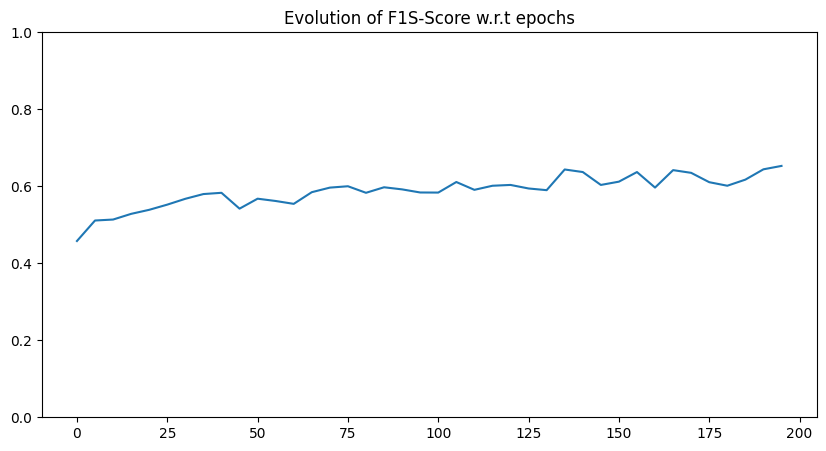

In [8]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()

plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [21]:
from torch_geometric.nn import GATConv

class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, head):
      super(StudentModel, self).__init__()

      self.graphconv1 = graphnn.GATConv(input_size, hidden_size, head)
      self.graphconv2 = graphnn.GATConv(hidden_size * head, hidden_size, head)
      self.graphconv3 = graphnn.GATConv(hidden_size * head, output_size, head, concat=False)

      self.elu = nn.ELU()
      ####### YOUR ANSWER #######

  def forward(self, x, edge_index):

      x = self.graphconv1(x, edge_index)
      x = self.elu(x)
      x = self.graphconv2(x, edge_index)
      x = self.elu(x)
      x = self.graphconv3(x, edge_index)
      return x
      ####### YOUR ANSWER #######

Let's train your model !

In [22]:
## Student model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes, head=5).to(device)

max_epochs = 200
### DEFINE LOSS FUNCTION AND OPTIMIZER
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN

epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.7223
F1-Score: 0.4353
Epoch 00002 | Loss: 0.5679
Epoch 00003 | Loss: 0.5406
Epoch 00004 | Loss: 0.5258
Epoch 00005 | Loss: 0.5203
Epoch 00006 | Loss: 0.5109
F1-Score: 0.5079
Epoch 00007 | Loss: 0.5033
Epoch 00008 | Loss: 0.4987
Epoch 00009 | Loss: 0.4936
Epoch 00010 | Loss: 0.4854
Epoch 00011 | Loss: 0.4808
F1-Score: 0.5126
Epoch 00012 | Loss: 0.4766
Epoch 00013 | Loss: 0.4816
Epoch 00014 | Loss: 0.4756
Epoch 00015 | Loss: 0.4656
Epoch 00016 | Loss: 0.4566
F1-Score: 0.5589
Epoch 00017 | Loss: 0.4500
Epoch 00018 | Loss: 0.4443
Epoch 00019 | Loss: 0.4420
Epoch 00020 | Loss: 0.4430
Epoch 00021 | Loss: 0.4348
F1-Score: 0.6159
Epoch 00022 | Loss: 0.4270
Epoch 00023 | Loss: 0.4200
Epoch 00024 | Loss: 0.4155
Epoch 00025 | Loss: 0.4053
Epoch 00026 | Loss: 0.3989
F1-Score: 0.6544
Epoch 00027 | Loss: 0.3952
Epoch 00028 | Loss: 0.3990
Epoch 00029 | Loss: 0.4171
Epoch 00030 | Loss: 0.3983
Epoch 00031 | Loss: 0.3853
F1-Score: 0.6669
Epoch 00032 | Loss: 0.3757
Ep

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.9413


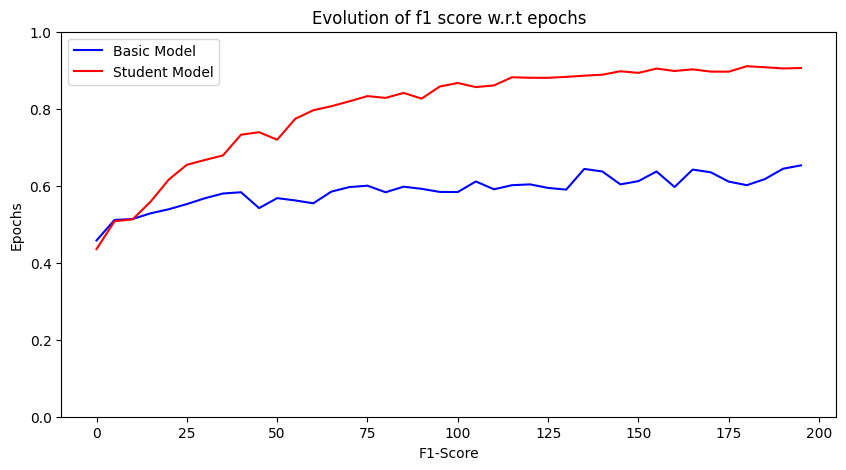

In [23]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

>Answer

1.

The basic model is based on the graph convolutional network layer, while our student model is based on the graph attention network layer.

The GAT layer is more efficient because it does not require costly matrix operations, and is parallelizable across all nodes in the graph, and it allows for assigning different importances to different nodes within a neighborhood while dealing with different sized neighborhoods, and does not knowing the entire graph structure upfront.

2.

The F1-Score is a metric used in classification problems to evaluate the performance of a model. It ranges from 0 to 1 with 1 being the best possible score, and it  is particularly useful for uneven class distribution.

From the graph above, our student model's F1-Score is around 0.94, making a large improvement from the base model. Since F1-Score presents the performance of a model with uneven class distribution, thus this result is convincing and our model performs well on the dataset.


**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ?
2. Are there solutions to overcome it ?
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

> Answer

1.

Oversmoothing refers to the situation where in our GNN model, the node representations converge to indistinguishable vectors after many layers of message passing.

Oversmoothing is raised because of the aggregation process in each GNN layer, and it is crucial because we will end up with similar embeddings for nodes that don't have the same label, which will result in mislabeling.

2.

There are some solutions to overcome this issue.

3.

Our model with GAT layers can efficiently deal with voersmoothing. Because the attention mechanism allows the network to learn a different weight for neighbor nodes, and the model hence would capture more nuanced relationships between nodes. This could help the model avoid ending up with same embeddings for nodes.